In [24]:
# load modules
import os
import sys
import gzip
import numpy as np
# import scipy.stats as stats
import pandas as pd
import pickle
# import bhtsne this doesnt work on my VM for some reason (or computer or anywhere)
import anndata
import scanpy
import scipy #make sure to pip install scipy==1.5.1, seems to be errors with the new one
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
import collections
from scipy.io import mmread,mminfo
from sklearn.manifold import TSNE
from collections import OrderedDict
# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from google.cloud import storage
import umap

from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
import itertools
from scipy import linalg
import pickle
from sklearn.neighbors import kneighbors_graph


import random
##function to generate random colors for coloring clusters
def random_colors(n): #n is the number of colors you need to generate
    color_set = np.zeros((n,3))
    for i in range(n):
        r = random.uniform(0, 1)
        b = random.uniform(0, 1)
        g = random.uniform(0, 1)
        color_set[i] = [r,b,g]
    return color_set

In [2]:
def graph_patients(df_list, names_list, xrange=None):
    fig = plt.figure(figsize=[4 * len(df_list), 4])
    for i, sample in enumerate(df_list):
        ms = np.log10(sample.sum(axis=1)) #library size
        # Figure
        ax = fig.add_subplot(1, len(df_list), i+1)
        ax.hist(ms,50,xrange)
        ax.set_title(names_list[i])
        ax.set_xlabel('log10 of library size')
def cell_filter(threshold, sample):
    ms = sample.sum(axis = 1) #library size 
    use_cells = ms.index[np.log10(ms) > threshold]
    sample = sample.loc[use_cells]
    print(sample.shape)
    return sample

# def gene_filter(sample,threshold=0):
#     before = sample.shape[1]
#     use_genes = sample.columns[sample.sum(axis=0) > threshold]
#     sample = sample[use_genes]
#     print(before - sample.shape[1] , "genes removed")
#     return sample

# loading in patient data

In [3]:
bucket_name = "visiumjuly2020"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "10778/MICHELLE_0212_AHJTWTDRXX__Project_10778__Sample_Patient2A_021120_IGO_10778_3/outs/filtered_feature_bc_matrix/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

barcodes_2A = pd.DataFrame()
features_2A = pd.DataFrame()


for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        if "barcodes" in str(file_name):
            df = pd.read_csv(file_name, header=None) # load the data
            barcodes_2A = df
        elif "features" in str(file_name):
            df = pd.read_csv(file_name, sep='\t',names=['geneID','gene_name','type']) # load the data
            features_2A = df
        elif "matrix" in str(file_name):
            matrix_2A = mmread(file_name)

my_prefix = "10778/MICHELLE_0212_AHJTWTDRXX__Project_10778__Sample_Patient2B_021120_IGO_10778_4/outs/filtered_feature_bc_matrix/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

barcodes_2B = pd.DataFrame()
features_2B = pd.DataFrame()


for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        if "barcodes" in str(file_name):
            df = pd.read_csv(file_name, header=None) # load the data
            barcodes_2B = df
        elif "features" in str(file_name):
            df = pd.read_csv(file_name, sep='\t',names=['geneID','gene_name','type']) # load the data
            features_2B = df
        elif "matrix" in str(file_name):
            matrix_2B = mmread(file_name)

                        
            

# process data 

In [4]:
#transposing matrix to cellsxgenes
matrix_2A_transpose = matrix_2A.transpose()
#creating anndata object 
ad_2A = anndata.AnnData(X=matrix_2A_transpose,obs=barcodes_2A,var=features_2A)
#creating dataframe
matrix_2A_transpose_dense=matrix_2A_transpose.todense()
df_2A = pd.DataFrame(matrix_2A_transpose_dense,columns=[x for x in features_2A['gene_name']])
barcodes_df_2A=barcodes_2A.join(df_2A)
df_2A.index = [f'A_{i}' for i in df_2A.index]

/home/cyp2111/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
#transposing matrix to cellsxgenes
matrix_2B_transpose = matrix_2B.transpose()
#creating anndata object 
ad_2B = anndata.AnnData(X=matrix_2B_transpose,obs=barcodes_2B,var=features_2B)
#creating dataframe
matrix_2B_transpose_dense=matrix_2B_transpose.todense()
df_2B = pd.DataFrame(matrix_2B_transpose_dense,columns=[x for x in features_2B['gene_name']])
barcodes_df_2B=barcodes_2B.join(df_2B)
df_2B.index = [f'B_{i}' for i in df_2B.index]

/home/cyp2111/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# FILTERING 

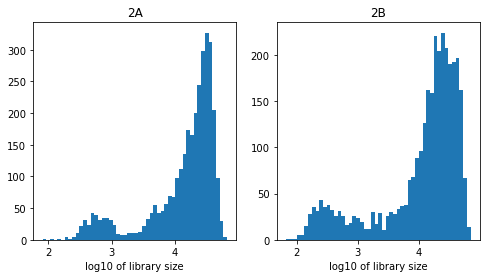

In [6]:
names = ['2A','2B']
dataframes = [df_2A,df_2B]
graph_patients(dataframes,names)

In [7]:
df_2A = cell_filter(3,df_2A)
df_2B = cell_filter(3,df_2B)

(2938, 33538)
(2770, 33538)


In [8]:
df2 = pd.concat([df_2A,df_2B])

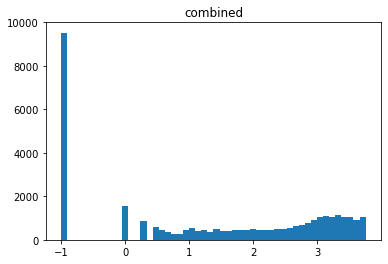

In [9]:
#get the count matrix for each sample set
binary = pd.DataFrame(df2)
binary = np.sign(binary)
binary.sum(axis=0) #sum number of cells a gene is expressed in
ms = np.log10(binary.sum(axis=0) + 0.1) #pseudo count and median lib size happens after 
# ms = counts.sum(axis=1)
# Figure
#create figures for each dataset 
plt.figure()
plt.hist(ms, bins=50)
plt.title("combined")  
plt.show()

In [10]:
##Getting rid of noisy genes
# Counts
THRESHOLD = 1
counts = df2
binary = pd.DataFrame(counts)
binary = np.sign(binary)

# Genes passing the threshold
ms =np.log10(binary.sum(axis = 0) + 0.1)
use_genes = ms.index[ms >= THRESHOLD]

# Update counts
df2 = counts.loc[:, use_genes]

# NORMALIZE AND PCA

In [11]:
ms = df2.sum(axis=1) #library size
norm_df = df2.div(ms, axis=0).mul(np.median(ms), axis=0)
log_norm_df = np.log(0.1+ norm_df)

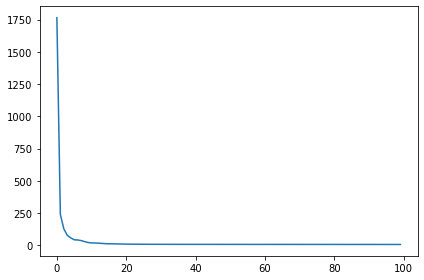

In [12]:
# PCA
no_eigs = 100
pca = PCA(n_components=no_eigs)
pca.fit(log_norm_df.values)
# Get Eiganvectors
eig_vectors = pca.components_
# Get Eiganvalues
eig_values = pca.explained_variance_
plt.plot(eig_values)
plt.tight_layout()

In [13]:
pca= PCA(n_components=20)
pca_projections = pd.DataFrame(pca.fit_transform(log_norm_df),
                index=log_norm_df.index)

In [14]:
tsne_output = TSNE(n_components=2, perplexity = 30).fit_transform(pca_projections)
tsne = pd.DataFrame(tsne_output, index=pca_projections.index, columns=['x', 'y'])

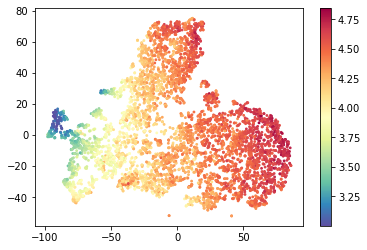

In [15]:
plt.scatter(tsne['x'], tsne['y'], s=8,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms +0.1))
plt.colorbar()

In [16]:
umap_data = umap.UMAP()
results = umap_data.fit_transform(pca_projections);
umap_ = pd.DataFrame(results, index=pca_projections.index, columns=['x', 'y'])

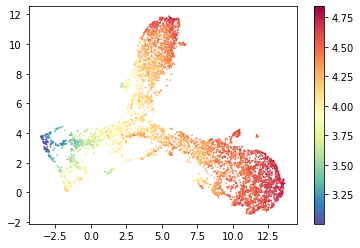

In [17]:
plt.scatter(results[:, 0],results[:, 1],s=3,edgecolors='none', cmap=matplotlib.cm.Spectral_r, c=np.log10(ms+0.1))
plt.colorbar()

# CLUSTERING

In [18]:
knn = kneighbors_graph(pca_projections,n_neighbors = 30, mode='distance', metric = 'manhattan', include_self = True)
communities, graph, Q = phenograph.cluster(knn)

Using neighbor information from provided graph, rather than computing neighbors directly
Jaccard graph constructed in 1.6075096130371094 seconds
Wrote graph to binary file in 0.5107336044311523 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801512
After 12 runs, maximum modularity is Q = 0.803053
Louvain completed 32 runs in 5.050669193267822 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.538570404052734 seconds


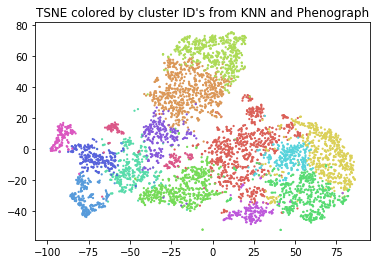

In [19]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = pca_projections.index, columns = ID)
color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = tsne.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(tsne.loc[cells, 'x'], tsne.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

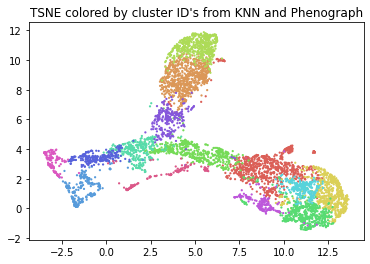

In [20]:
ID =["ID"]
n_cluster_knn = np.amax(communities)
cluster_ID_knn = pd.DataFrame(communities, index = pca_projections.index, columns = ID)
color_set = pd.Series(list(sns.color_palette('hls', n_cluster_knn)))
num_in_cluster = np.zeros(n_cluster_knn)
i=0
for cluster in range(n_cluster_knn):
    bool_array = cluster_ID_knn.ID == cluster
    cells = umap_.index[bool_array]
    num_in_cluster[i] = len(cells)
    plt.scatter(umap_.loc[cells, 'x'], umap_.loc[cells, 'y'],
        s=5, edgecolors='none', color=color_set[cluster])
    i +=1
plt.title("TSNE colored by cluster ID's from KNN and Phenograph")
plt.show()

In [22]:
# tsne.to_pickle("./tsne.pkl")
# umap_.to_pickle("./umap.pkl")
# df2.to_pickle("./df2.pkl")
# pca_projections.to_pickle("./pca_projections.pkl")
# log_norm_df.to_pickle("./log_norm_df.pkl")
# cluster_ID_knn.to_pickle("./cluster_ID.pkl")

# NMF 

In [3]:
tsne = pd.read_pickle("./tsne.pkl")
umap_ = pd.read_pickle("./umap.pkl")
df2 = pd.read_pickle("./df2.pkl")
pca_projections = pd.read_pickle("./pca_projections.pkl")
log_norm_df = pd.read_pickle("./log_norm_df.pkl")
cluster_ID = pd.read_pickle("./cluster_ID.pkl")
communities = cluster_ID["ID"]
df = pd.DataFrame(np.array(communities), columns= ["cluster" ], index = df2.index)
df["index"] = np.arange(len(df))
#how to load weights
# loaded_arr = np.loadtxt("weights.txt") 
# load_original_arr = loaded_arr.reshape(1,n_components, len(df2))

#### LIST OF ALL FILES THAT HAVE BEEN PICKLED FROM NMF
##### 10 components with L1 regularizer: 
H_10comp_L1.pkl \\
W_10comp_L1.pkl \\
W_norm_10comp_L1.pkl

##### 20 components with L1 regularizer:
H_20comp_L1.csv
W_20comp_L1.csv
W_norm_20comp_L1.csv

##### 25 components with L1 regularizer:
H_25components_L1.pkl \\
weights_25comp_L1.csv \\
norm_weights_25comp_L1.csv


In [4]:
#functions for NMF model 
#function takes in a specific cluster and outputs an array with the indicies of all spots assigned to that cluster
def cluster_index(cluster, df):
    a = df.loc[df["cluster"] == cluster]
    array = np.array(a["index"])
    return array
#function runs NMF for specified components and initialization parameters (use raw count matrix)
#use l1_ratio=1 for L1 regularizer, and init='nndsvd' for sparsity
def nmf_function(n_components, init, l1_ratio, df2):
    # fit model on all data (count matrices)
    model = NMF(n_components=n_components, init = init,l1_ratio = l1_ratio, max_iter=10000)
    nmf = model.fit(df2)
    H = nmf.components_
    H = pd.DataFrame(H, columns = df2.columns)
    # now transform each spot 
    W = np.zeros((1,n_components, len(df2)))
    for spot in range(len(df2)):
        spot_array = np.array(df2.iloc[spot]).reshape(1, -1)
        W[:,:,spot] = nmf.transform(spot_array)
    W_norm = np.zeros((1,n_components, len(df2)))
    for spot in range(len(df2)):
        norm = np.linalg.norm(W[:,:,spot])
        W_norm[:,:,spot] = W[:,:,spot]/norm
    return H,W,W_norm

def save(H,W,W_norm,name1, name2, name3):
    H.to_csv(name1)
    W_reshape = W.reshape(W.shape[0], -1) 
    np.savetxt(name2, W_reshape) 
    W_reshape_norm = W_norm.reshape(W_norm.shape[0], -1) 
    np.savetxt(name3, W_reshape_norm) 
    return

# getting the weights for all spots in each cluster

def spot_weights_by_cluster(n_components,communities, df, W_norm):
    n_cluster_knn = np.amax(communities)
    sum_test = 0
    for cluster in range(n_cluster_knn + 1):
        #gives the indices for all cells in that cluster
        arr = cluster_index(cluster, df)
        sum_test += len(arr)
        cluster_arr = np.zeros((1,n_components,len(arr)))
        i = 0
        for spot in range(len(df2)):
            if spot not in arr:
                continue
            elif spot in arr:
                cluster_arr[:,:,i] = W_norm[:,:,spot]
                i += 1
        cluster_dict[cluster] = cluster_arr
    return cluster_dict

#getting average weights for each cluster 
def avg_weights_by_cluster(n_components,communities, cluster_dict):
    n_cluster_knn = np.amax(communities)
    for cluster in range(n_cluster_knn + 1):
        cluster_W = cluster_dict[cluster]
        arr = np.zeros((1,n_components))
        for i in range(n_components):
            arr[:,i] = np.mean(cluster_W[:,i,:])
        norm = np.linalg.norm(arr)
        arr = arr/norm
        avg_dict[cluster] = arr
    return avg_dict

#filtering to decrease number of graphed components
def filter_components(threshold, n_components,communities, dictionary):
    n_cluster_knn = np.amax(communities)
    for cluster in range(n_cluster_knn + 1):
        a = dictionary[cluster].flatten()
        for i in range(n_components):
            if a[i]<threshold:
                a[i] = 0
        norm = np.linalg.norm(a)
        a = a/norm
        filt_dict[cluster] = a
    return filt_dict

In [34]:
from scipy import stats
clust = cluster_df[cluster_df["cluster_number"] == 0]
non_cluster = cluster_df[cluster_df["cluster_number"] != 0]
n_genes = clust.shape[1]
p_corr = np.zeros(n_genes)
gene_expression = clust.sum(axis = 0).div(len(clust))
non_clust_exp = non_cluster.sum(axis = 0).div(len(non_cluster))
#     p_corr[i] = stats.pearsonr(gene_expression, non_clust_exp)[0]

In [36]:
stats.pearsonr(gene_expression, non_clust_exp)[0]

0.9936449038850379

In [ ]:
#get list of top N genes for each cluster
def deg(df2, N, n_cluster_knn):
    array = []
    cluster_df = pd.DataFrame(df2)
    cluster_df["cluster_number"] = df["cluster"]
    for cluster in range(n_cluster_knn + 1):
        clust = cluster_df[cluster_df["cluster_number"] == cluster]
        n_genes = clust.shape[1]
        p_corr = np.zeros(n_genes)
        for i in range(n_genes):
            gene_expression = clust.iloc[:,i]
            p_corr[i] = stats.pearsonr(gene_expression, data[:,1])[0]
        col_names=[ "pearson"]
        pearson = pd.DataFrame(p_corr, index = counts_transpose.columns, columns=col_names)
        pearson_high = pearson.sort_values(by = ['pearson'], ascending= False)
        gene_set = np.array(pearson_high.index[0:N])
        
    return array



n_genes = len(counts_transpose.columns)
p_corr = np.zeros(n_genes)
for i in range(n_genes):
    gene_expression = counts_transpose.iloc[:,i]
    p_corr[i] = stats.pearsonr(gene_expression, data[:,1])[0]
col_names=[ "pearson"]
pearson = pd.DataFrame(p_corr, index = counts_transpose.columns, columns=col_names)

pearson_high = pearson.sort_values(by = ['pearson'], ascending= False)
gene_set = np.array(pearson_high.index[0:10])
gene = np.reshape(gene_set, (len(gene_set),1))



In [196]:
n_components = 10
H10,W10,W_norm10 = nmf_function(n_components,'nndsvd',1,df2)
# save(H10,W10,W_norm10, "./H_10comp_L1.csv","./W_10comp_L1.csv","./W_norm_10comp_L1.csv")
cluster_dict = OrderedDict()
cluster_dict = spot_weights_by_cluster(n_components,communities, df, W_norm10)
clust_dict = cluster_dict.copy()

avg_dict=OrderedDict()
avg_dict = avg_weights_by_cluster(n_components,communities, clust_dict)
test_dict = avg_dict.copy()

filt_dict = OrderedDict()
filt_dict = filter_components(0.25, n_components, communities, test_dict)

In [7]:
n_components = 15
H,W,W_norm = nmf_function(n_components,'nndsvd',1,df2)
save(H,W,W_norm, "./H_15comp_L1.csv","./W_15comp_L1.csv","./W_norm_15comp_L1.csv")
n_cluster_knn = np.amax(communities)
cluster_dict = OrderedDict()
cluster_dict = spot_weights_by_cluster(n_components,communities, df, W_norm)
clust_dict = cluster_dict.copy()

avg_dict=OrderedDict()
avg_dict = avg_weights_by_cluster(n_components,communities, clust_dict)
test_dict = avg_dict.copy()

filt_dict = OrderedDict()
filt_dict = filter_components(0.25, n_components, communities, test_dict)

In [6]:
n_components = 20
H,W,W_norm = nmf_function(n_components,'nndsvd',1,df2)
save(H,W,W_norm, "./H_20comp_L1.csv","./W_20comp_L1.csv","./W_norm_20comp_L1.csv")
n_cluster_knn = np.amax(communities)
cluster_dict = OrderedDict()
cluster_dict = spot_weights_by_cluster(n_components,communities, df, W_norm)
clust_dict = cluster_dict.copy()

avg_dict=OrderedDict()
avg_dict = avg_weights_by_cluster(n_components,communities, clust_dict)
test_dict = avg_dict.copy()

filt_dict = OrderedDict()
filt_dict = filter_components(0.25, n_components, communities, test_dict)

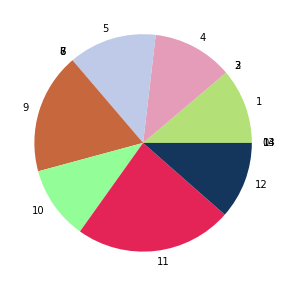

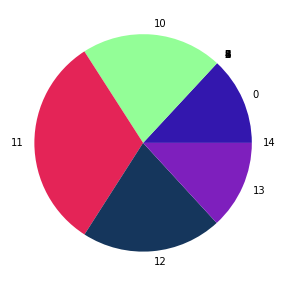

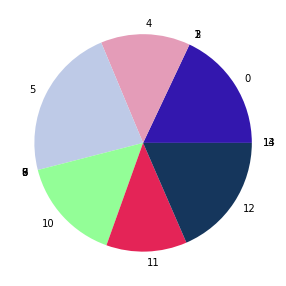

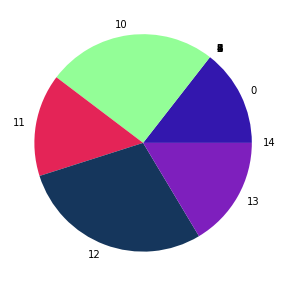

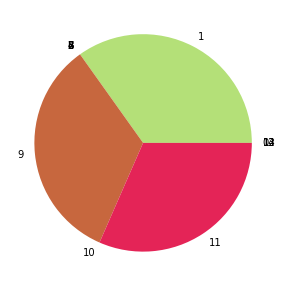

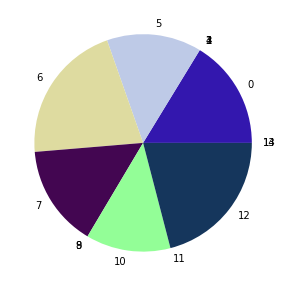

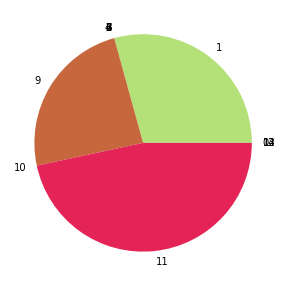

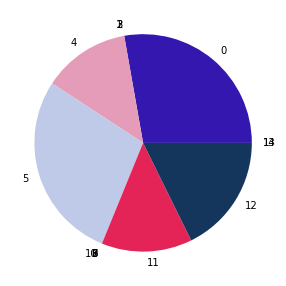

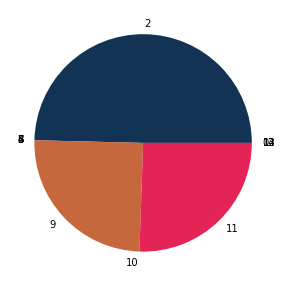

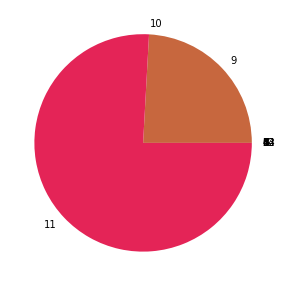

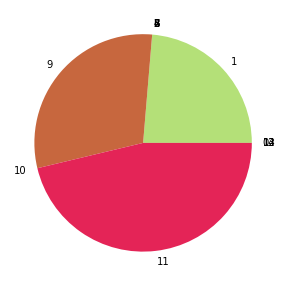

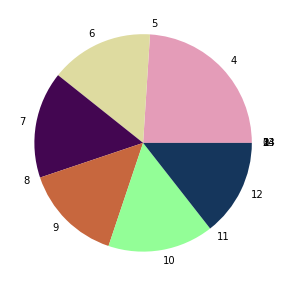

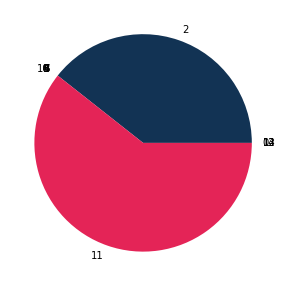

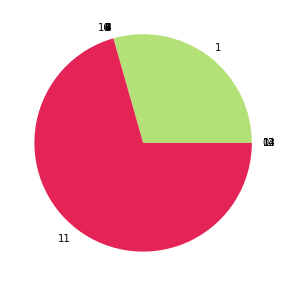

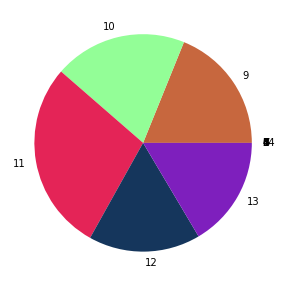

In [8]:
#pie chart for each component
color_set = random_colors(n_components+2)
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure(figsize = (5,5))
    plt.pie(filt_dict[k].flatten(), labels = x, colors = color_set)
    plt.show()

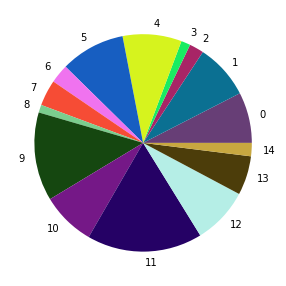

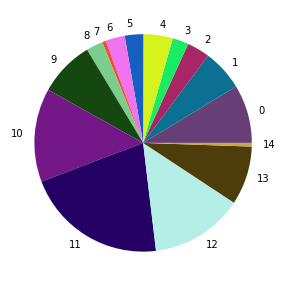

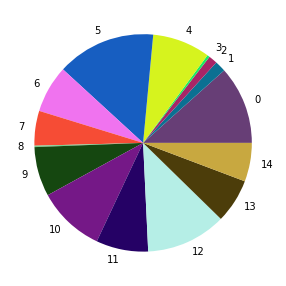

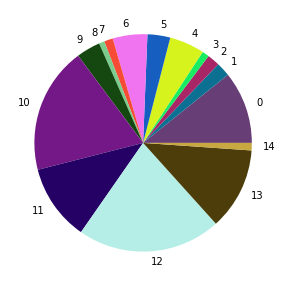

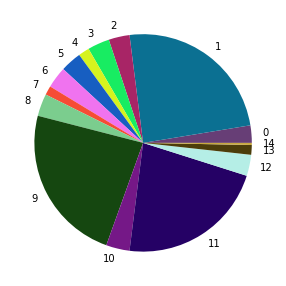

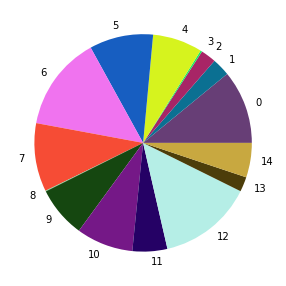

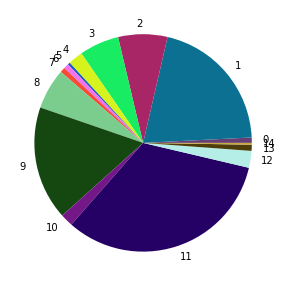

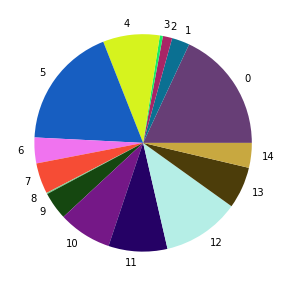

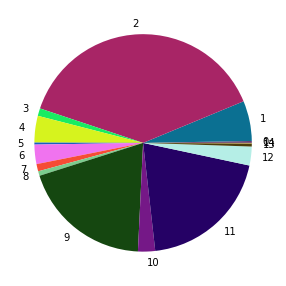

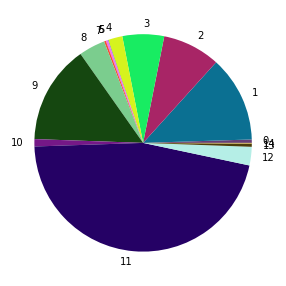

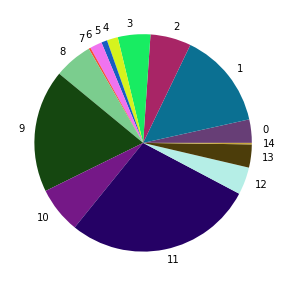

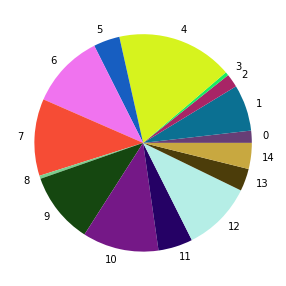

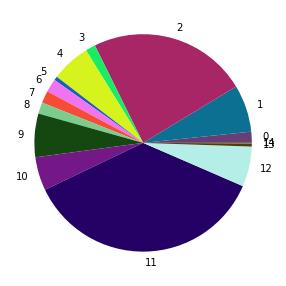

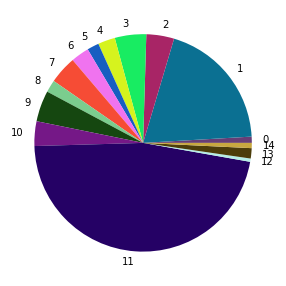

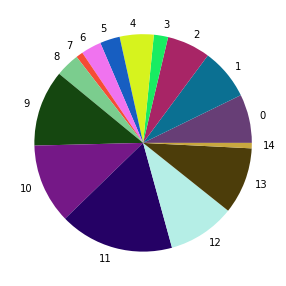

In [9]:
color_set = random_colors(n_components+2)
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure(figsize = (5,5))
    plt.pie(avg_dict[k].flatten(), labels = x, colors = color_set)
    plt.show()

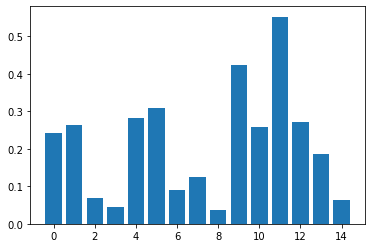

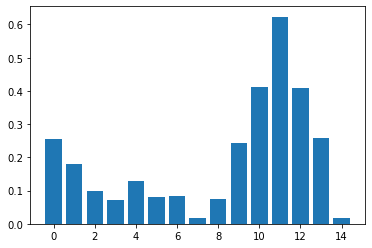

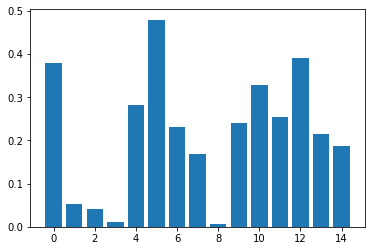

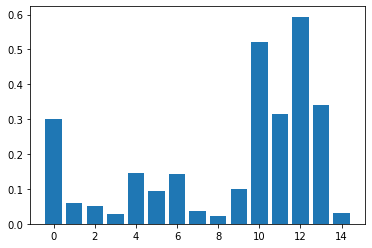

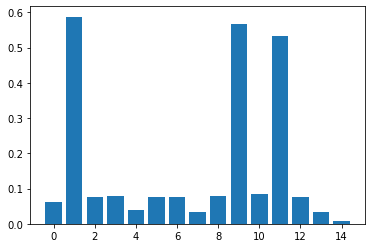

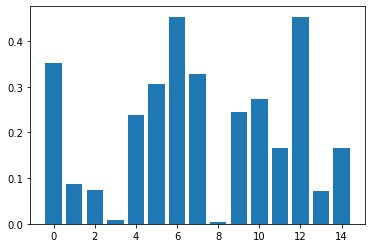

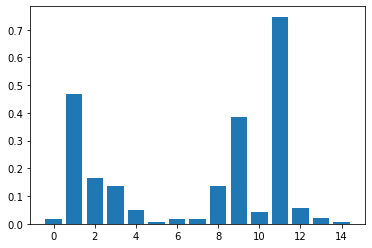

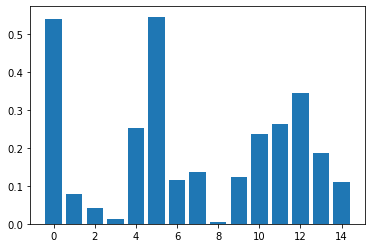

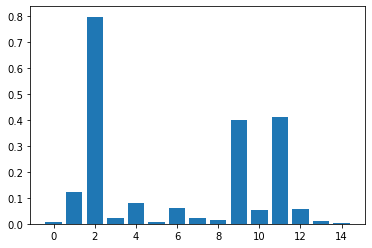

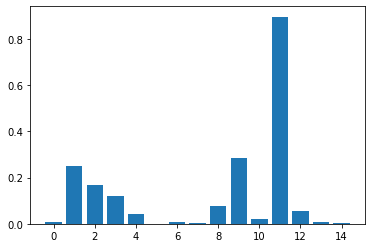

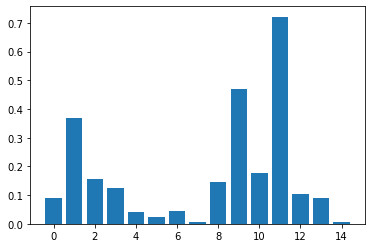

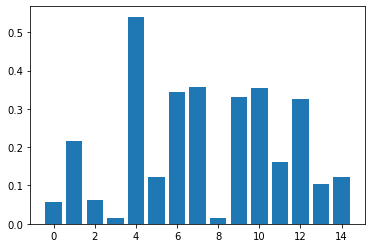

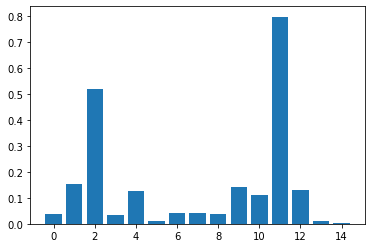

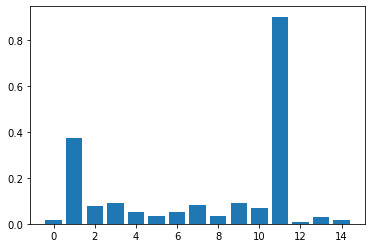

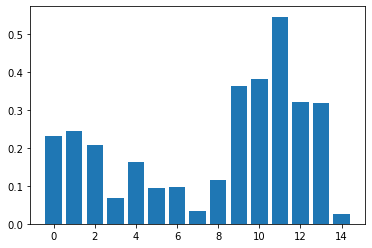

In [10]:
#histogram chart for UNFILTERED components showing ratio of each component for each cluster
x = np.arange(n_components)
for k in range(n_cluster_knn + 1):
    plt.figure()
    plt.bar(x,avg_dict[k].flatten())
    plt.show()


# GMM 

In [22]:
#look at a single cluster
data_df = pd.DataFrame(df2.astype(np.float32))
data_df["cluster"] = communities

In [23]:
cluster_13 = data_df.loc[data_df["cluster"] == 13] 
cluster_13 = cluster_13.drop(columns = "cluster")
cluster_13 = cluster_13.astype(np.float32)
cluster_13_transpose = cluster_13.transpose()

In [24]:
avg_13 = np.array(cluster_13.sum(axis = 0))
avg_13 = avg_13.reshape(-1, 1)

In [26]:
cluster_13_transpose

,A_12,A_14,A_18,A_33,A_34,A_59,A_106,A_166,A_183,A_186,...,A_3209,A_3237,B_342,B_400,B_936,B_1076,B_1165,B_1260,B_2835,B_2905
AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL732372.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL669831.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL669831.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC00115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAFIP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL592183.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC007325.4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL354822.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
%%time 
gmm = GaussianMixture(n_components=5).fit(cluster_13_transpose)
# pickle.dump(gmm, open( f"{path}/gmm.p", "wb" ) )

CPU times: user 47min 42s, sys: 59.8 s, total: 48min 42s
Wall time: 6min 54s


In [32]:
%%time 
gmm_withpredict = GaussianMixture(n_components=5).fit_predict(cluster_13_transpose)

CPU times: user 11.4 s, sys: 262 ms, total: 11.7 s
Wall time: 3.31 s


In [34]:
cluster_13_transpose['A_14']

AL627309.1    0.0
AL732372.1    0.0
AL669831.2    0.0
AL669831.5    0.0
LINC00115     0.0
             ... 
MAFIP         0.0
AL592183.1    0.0
AC007325.4    0.0
AL354822.1    0.0
AC240274.1    0.0
Name: A_14, Length: 19263, dtype: float32

In [ ]:
# consider adding in gene name or specific index to make 2D array

In [28]:
%%time 
gmm_withpredict = GaussianMixture(n_components=5).fit_predict(np.array(cluster_13_transpose['A_14']).reshape(-1,1))

CPU times: user 771 ms, sys: 16.6 ms, total: 788 ms
Wall time: 223 ms


In [29]:
predictions = pd.DataFrame(gmm_withpredict, index = cluster_13_transpose['A_14'].index, columns = ["A14"])

In [31]:
params = {}
k = 0
for i in range(len(gmm_withpredict)):
    key = gmm_withpredict[i]
    if key == 2:
        k += 1
    if key in params:
        
        params[key] += 1
    else: 
        params[key] = 1
print(params)

{0: 14991, 2: 974, 4: 263, 3: 3034, 1: 1}


In [62]:
genes = {}
genes_0 = predictions.loc[predictions["A14"] == 0]
genes[0] = np.array(genes_0.index)
genes_1 = predictions.loc[predictions["A14"] == 1]
genes[1] = np.array(genes_1.index)
genes_2 = predictions.loc[predictions["A14"] == 2]
genes[2] = np.array(genes_2.index)
genes_3 = predictions.loc[predictions["A14"] == 3]
genes[3] = np.array(genes_3.index)
genes_4 = predictions.loc[predictions["A14"] == 4]
genes[4] = np.array(genes_4.index)

In [90]:
A14 = pd.DataFrame(cluster_13_transpose['A_14'])
A14["cluster"] = predictions['A14']

In [109]:
for i in range(3):
    print(i)
    bool_array = A14["cluster"] == i
    subset = A14.loc[bool_array]
    col = subset["A_14"]
    print(np.mean(col))

0
0.0
1
4.898357391357422
2
817.0


In [33]:
plt.plot(cluster_13_transpose['A_14'])

Error in callback <function flush_figures at 0x7fb309c17550> (for post_execute):


KeyboardInterrupt: 

In [ ]:
%%time
#kernel dies with this one
# bayes_gmm = BayesianGaussianMixture(n_components=5, covariance_type='full').fit(cluster_13)
# pickle.dump(bayes_gmm, open( f"{path}/bayes_gmm.p", "wb" ) )

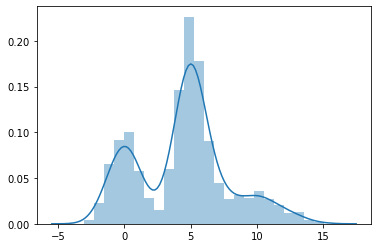

In [143]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(37)

x0 = np.random.normal(0, 1, 500)
x1 = np.random.normal(5, 1, 1000)
x2 = np.random.normal(10, 2, 300)
X = np.concatenate([x0, x1, x2]).reshape(-1, 1)

sns.distplot(X)

Ideas moving forward:

cam
- potentially look into non negative matrix factorization (cam) 

joy
- fit_predict approach (joy)
- train model on all spots in entire slice to try and learn gene associations then take that model and predict on spots (joy)

lauren
- work on tuning GMM for single spots and recreate celle expression matrices for cellassign (Lauren) 

(time permitting) 
- filter out spots with non conflicting gene expression
- filter out genes (either 0 expression or non-variable expression) (first pass remove 0/low expression) expression genes
- potentially look into ratios of library size/UMIs to get number of cells
- how to visualize cellassign output? 